In [2]:
! pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 51.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 116.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 91.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 39.9 MB/s eta 0:00:00


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import copy
%matplotlib inline

In [ ]:
df = pd.read_csv('./Ethos_Dataset_Multi_Label.csv',sep=';')
df.columns

Index(['comment', 'violence', 'directed_vs_generalized', 'gender', 'race',
       'national_origin', 'disability', 'religion', 'sexual_orientation'],
      dtype='object')

In [ ]:
df

,comment,violence,directed_vs_generalized,gender,race,national_origin,disability,religion,sexual_orientation
0,You should know women's sports are a joke,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,You look like Sloth with deeper Down’s syndrome,0.000000,0.833333,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
2,You look like Russian and speak like Indian. B...,1.000000,0.500000,0.142857,0.142857,0.714286,0.000000,0.000000,0.000000
3,"Women deserve to be abused, I guess.",0.666667,0.166667,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Women are made for making babies and cooking d...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
428,All people are fucked up because of these quee...,0.000000,0.000000,0.571429,0.000000,0.000000,0.000000,0.000000,0.571429
429,Actually THIS WEIRD PEOPLE are HARMFUL! They n...,0.000000,1.000000,0.000000,0.000000,0.333333,0.666667,0.000000,0.000000
430,ABU DA BI ABA DU BA BA HAMUD! See? I’m an arab...,0.000000,0.000000,0.000000,0.285714,0.000000,0.000000,0.857143,0.000000
431,a homo? so you fuck your brother instead of yo...,0.000000,0.666667,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


In [ ]:
labels = ['violence', 'gender', 'race', 'national_origin', 'disability', 'religion', 'sexual_orientation']
text = df['comment']
label_df = df[labels]


In [ ]:
def transform_labels(record):
    record = copy.deepcopy(record)
    _max  = record.argmax()
    for l, v in record.items():
        if l != record.index[_max]:
            record[l] = 0
        else:
            record[l] = 1
    return record

l_tmp = label_df.apply(transform_labels, axis=1)

In [ ]:
l_tmp

,violence,gender,race,national_origin,disability,religion,sexual_orientation
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
428,0.0,1.0,0.0,0.0,0.0,0.0,0.0
429,0.0,0.0,0.0,0.0,1.0,0.0,0.0
430,0.0,0.0,0.0,0.0,0.0,1.0,0.0
431,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
l_tmp.isna().sum()

violence              0
gender                0
race                  0
national_origin       0
disability            0
religion              0
sexual_orientation    0
dtype: int64

In [5]:
import tensorflow as tf
from transformers import TFBertModel, BertTokenizer
from tensorflow.keras.layers import Input, Dense, Activation, Flatten
from tensorflow.keras.models import Model
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import to_categorical


In [6]:
# Load pre-trained BERT model
bert_model = TFBertModel.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
max_sequence_length = 128

In [ ]:
def preprocess_text_data(text_data, max_sequence_length):
    input_ids = []
    for text in text_data:
        tokens = tokenizer(text, padding='max_length', truncation=True, max_length=max_sequence_length, return_tensors="tf")['input_ids'][0]
        input_ids.append(tokens)
    return tf.convert_to_tensor(input_ids)

In [ ]:
text_tokenized = preprocess_text_data(text, max_sequence_length)

In [ ]:
text_tokenized.numpy()

array([[  101,  2017,  2323, ...,     0,     0,     0],
       [  101,  2017,  2298, ...,     0,     0,     0],
       [  101,  2017,  2298, ...,     0,     0,     0],
       ...,
       [  101,  8273,  4830, ...,     0,     0,     0],
       [  101,  1037, 24004, ...,     0,     0,     0],
       [  101,  1006,  1006, ...,     0,     0,     0]], dtype=int32)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(text_tokenized.numpy(), l_tmp, test_size=0.2, random_state=42)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((346, 128), (87, 128), (346, 7), (87, 7))

In [ ]:
 y_train.shape

(346, 7)

In [ ]:
## Model archi

num_classes = 7

input_text = Input(shape=(max_sequence_length,), dtype=tf.int32)

# Get BERT model's output
bert_output = bert_model(input_text)[0]

# Freeze BERT layers
for layer in bert_model.layers:
    layer.trainable = False

# Add fully connected layers with tanh activation
x = Dense(256, activation='tanh')(bert_output)
x = Flatten()(Dense(128, activation='tanh')(x))

# Add the output layer for classification
output = Dense(num_classes, activation='softmax')(x)

# Create a Keras model
model = Model(inputs=input_text, outputs=output)

# Compile the model with appropriate loss and optimizer
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)


In [ ]:
epochs=15
batch_size=32

# Train the model with dropout layers
history = model.fit(X_train, y_train, epochs=epochs, validation_split=0.1, shuffle=True, batch_size=batch_size)

Epoch 1/15
10/10 [==============================] - 22s 781ms/step - loss: 3.9872 - accuracy: 0.1511 - val_loss: 3.4087 - val_accuracy: 0.2571
Epoch 2/15
10/10 [==============================] - 3s 311ms/step - loss: 3.0688 - accuracy: 0.2540 - val_loss: 2.8241 - val_accuracy: 0.1714
Epoch 3/15
10/10 [==============================] - 3s 311ms/step - loss: 1.9925 - accuracy: 0.3248 - val_loss: 2.4407 - val_accuracy: 0.2000
Epoch 4/15
10/10 [==============================] - 3s 320ms/step - loss: 1.5936 - accuracy: 0.4116 - val_loss: 2.2169 - val_accuracy: 0.1714
Epoch 5/15
10/10 [==============================] - 3s 317ms/step - loss: 0.9995 - accuracy: 0.6785 - val_loss: 1.8438 - val_accuracy: 0.1429
Epoch 6/15
10/10 [==============================] - 3s 312ms/step - loss: 0.7905 - accuracy: 0.7717 - val_loss: 1.8094 - val_accuracy: 0.3429
Epoch 7/15
10/10 [==============================] - 3s 347ms/step - loss: 0.6114 - accuracy: 0.8939 - val_loss: 1.9091 - val_accuracy: 0.3429
Epoch

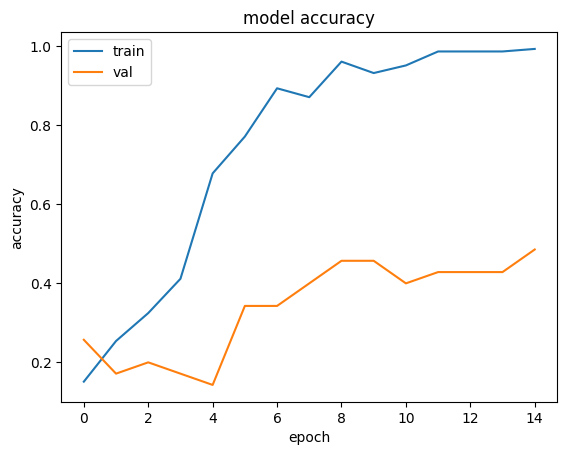

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

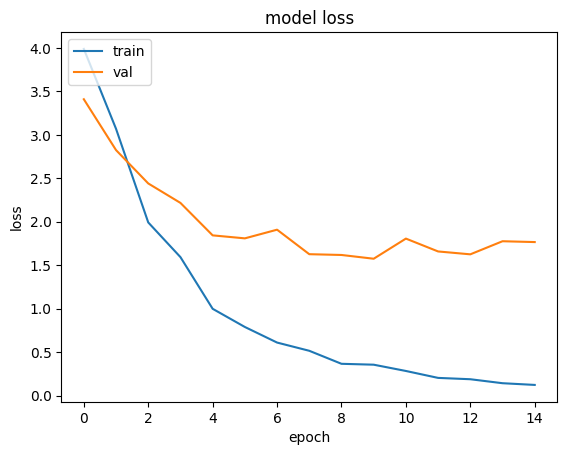

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()